In [ ]:
pip install -q tensorflow==2.9.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 33.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aipla

In [ ]:
import os
import tensorflow as tf
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/My Drive/Data/'

In [ ]:
double_tap_sequences = []
single_tap_sequences = []
no_tap_sequences = []

In [ ]:
for filename in os.listdir(directory + 'DOUBLE_TAP_DATA'):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory + 'DOUBLE_TAP_DATA', filename)
        df = pd.read_csv(filepath)

        #RawCount values from the dataset
        raw_counts = df['Proximity0_Sns0 RawCount'].values

        #Append the raw counts to the double tap sequences
        double_tap_sequences.append(raw_counts)


In [ ]:
# Single tap gestures
for filename in os.listdir(directory + 'SINGLE_TAP_DATA'):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory + 'SINGLE_TAP_DATA', filename)
        df = pd.read_csv(filepath)

        raw_counts = df['Proximity0_Sns0 RawCount'].values
        single_tap_sequences.append(raw_counts)


In [ ]:
# No tap gestures
for filename in os.listdir(directory + 'NO_TAP_DATA'):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory + 'NO_TAP_DATA', filename)
        df = pd.read_csv(filepath)

        raw_counts = df['Proximity0_Sns0 RawCount'].values
        no_tap_sequences.append(raw_counts)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to ensure they are all of length 100
double_tap_sequences = pad_sequences(double_tap_sequences, maxlen=100, padding='post')
single_tap_sequences = pad_sequences(single_tap_sequences, maxlen=100, padding='post')
no_tap_sequences = pad_sequences(no_tap_sequences, maxlen=100, padding='post')

In [ ]:
#lists to np arrays
double_tap_sequences = np.array(double_tap_sequences).reshape((50, 100, 1))
single_tap_sequences = np.array(single_tap_sequences).reshape((50, 100, 1))
no_tap_sequences = np.array(no_tap_sequences).reshape((50, 100, 1))

In [ ]:

#combining all gesture sequences
X = np.concatenate([double_tap_sequences, single_tap_sequences, no_tap_sequences], axis=0)


In [ ]:
#labels for each gesture type

y_double_tap = np.ones(50)  # 1 for double tap
y_single_tap = np.zeros(50)  # 0 for single tap
y_no_tap = 2 * np.ones(50)  # 2 for no tap


In [ ]:
#combining the labels into a single array
y = np.concatenate([y_double_tap, y_single_tap, y_no_tap], axis=0)


In [ ]:
#normalize data to 3d format to fed in the NN
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 100)).reshape(-1, 100, 1)


In [ ]:
#converting labels to categorical (one-hot encoding)
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes=3)

In [ ]:
#spliting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
#shifting function
def shift_data(data, max_shift=5):
    shift = random.randint(-max_shift, max_shift)
    return np.roll(data, shift, axis=1)


In [ ]:
#scaling function
def scale_data(data, scale_factor=0.01):
    scale = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    return data * scale

In [ ]:
# Data Augmentation function to add random noise
def augment_data(data, noise_factor=0.01, max_shift=5, scale_factor=0.01):
  noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
  shifted_data = shift_data(noisy_data, max_shift=max_shift)
  scaled_data = scale_data(shifted_data, scale_factor=scale_factor)
  return scaled_data



In [ ]:
# Augmented training data
X_train_augmented = augment_data(X_train)

#combining original and augmented data
X_train_combo = np.concatenate([X_train, X_train_augmented], axis = 0)
y_train_combo = np.concatenate([y_train, y_train], axis = 0)  # Labels remain the same

In [ ]:
print("X_train_combo shape:", X_train_combo.shape)
print("y_train_combo shape:", y_train_combo.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train_combo shape: (240, 100, 1)
y_train_combo shape: (240, 3)
X_test shape: (30, 100, 1)
y_test shape: (30, 3)


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Number of folds for cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Score for fold 1: compile_metrics of 97.91666865348816%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


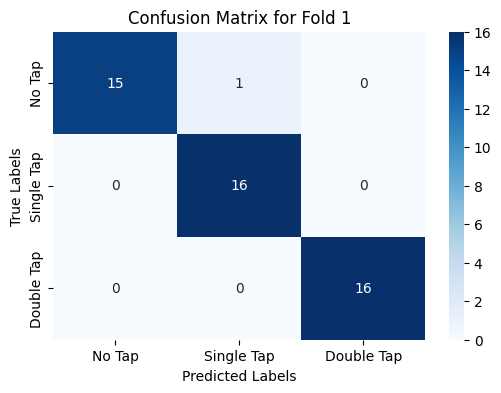

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Score for fold 2: compile_metrics of 91.66666865348816%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step


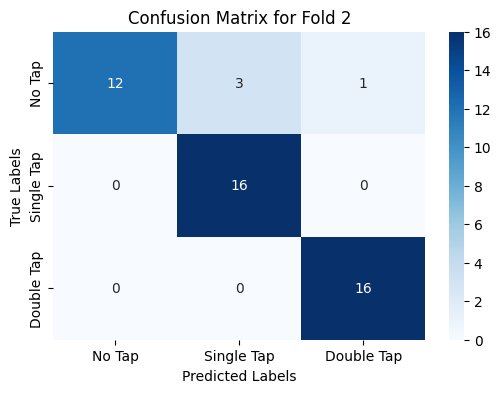

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Score for fold 3: compile_metrics of 89.58333134651184%


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


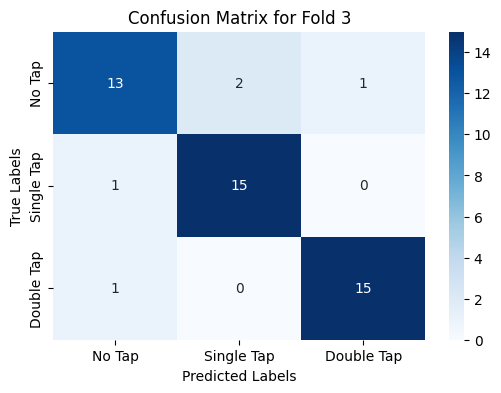

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Score for fold 4: compile_metrics of 95.83333134651184%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


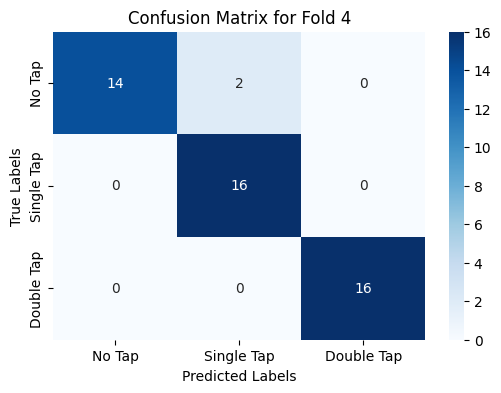

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Score for fold 5: compile_metrics of 87.5%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


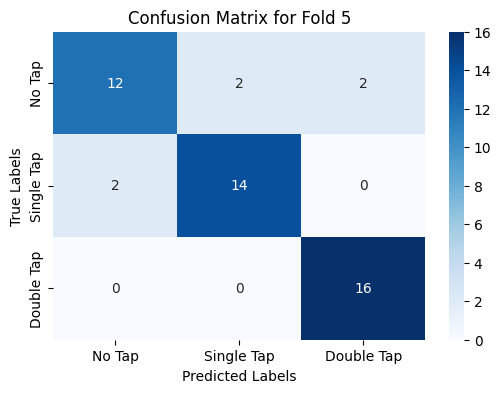

In [ ]:
#data to numpy arrays
X_data = np.array(X_train_combo)
y_data = np.array(y_train_combo)

#storing accuracy and confusion matrix for each fold
accuracy_per_fold = []
confusion_matrices = []

# Iterating over each fold
fold_no = 1
for train_index, val_index in skf.split(X_data, np.argmax(y_data, axis=1)):
    # Spliting the data into training and validation sets
    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Model Architecture
    model = Sequential()
    model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(100, 1))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Model training
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate Model on the validation set
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')

    accuracy_per_fold.append(scores[1] * 100)

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoding to class labels
    y_true_classes = np.argmax(y_val, axis=1)   # Convert one-hot encoding to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    confusion_matrices.append(cm)

    # Plot the confusion matrix for each fold
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tap', 'Single Tap', 'Double Tap'], yticklabels=['No Tap', 'Single Tap', 'Double Tap'])
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    fold_no += 1



In [ ]:
# Print the model architecture in text format
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (32, 100, 256)              │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (32, 100, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (32, 128)                   │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,771 (3.50 MB)

 Trainable params: 305,923 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 611,848 (2.33 MB)

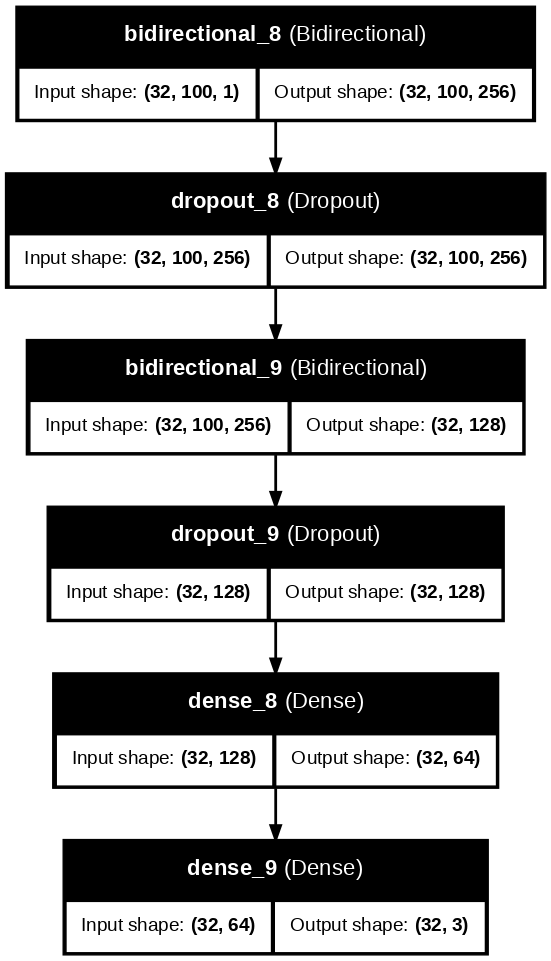

In [ ]:
from tensorflow.keras.utils import plot_model

# Save and display the model architecture
plot_model(model, to_file='bi_lstm_model.png', show_shapes=True, show_layer_names=True, dpi=100)


In [ ]:
#Overall accuracy
print(f'\nAverage accuracy across {k} folds: {np.mean(accuracy_per_fold)}%')


Average accuracy across 5 folds: 91.25%


In [ ]:
#Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'LSTM Accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8333 - loss: 0.4776
LSTM Accuracy: 83.33%


In [ ]:
# Saving the trained model
model.save("Gesture_detection_model.h5")


In [ ]:
import os

# Get the file size in bytes
file_size = os.path.getsize('Gesture_detection_model.h5')
print(f"Model size: {file_size / (1024 * 1024):.2f} MB")


Model size: 3.56 MB
